Needed dependencies:

  * q-alchemy-sdk-py
  * jupyter
  * matplotlib
  * pandas
  * scikit-learn
  * tqdm

In [1]:
import numpy as np
import qutip
import matplotlib.pyplot as plt

In [2]:
def plot_digits(digits, labels, matrix_dim, save_fig=None, fig_size=(20, 10)):
    fig, axes = plt.subplots(nrows=1, ncols=len(digits), figsize=fig_size, squeeze=False)
    for ax, digit, label in zip(axes.reshape(-1), digits, labels):
        ax.set_axis_off()
        image = digit[:int(matrix_dim**2)].reshape(matrix_dim, matrix_dim)
        ax.imshow(image, cmap=plt.cm.gray_r, interpolation='none')
        ax.set_title(label)
    if save_fig is not None:
        fig.savefig(save_fig)
    else:
        plt.show()
    plt.close(fig)

In [3]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, parser="auto")

## Fill up to even power of 2

In [4]:
qubits = int(np.ceil(np.log2(mnist.data.shape[1])))
filler = np.empty((mnist.data.shape[0], 2**qubits - mnist.data.shape[1]))
filler.fill(0)
embedded = np.hstack([mnist.data, filler])
embedded = np.einsum("ij,i -> ij", embedded, 1 / np.linalg.norm(embedded, axis=1)) 
all(np.linalg.norm(embedded, axis=1).round(13) == 1.0)

True

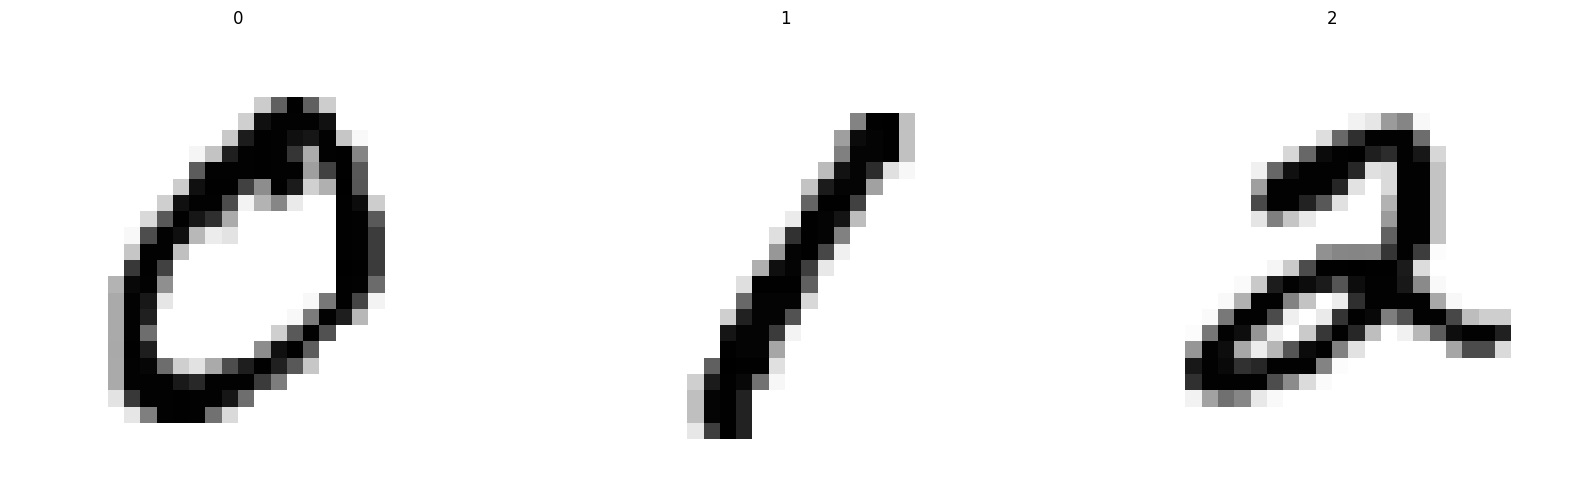

In [5]:
zeros = embedded[mnist.target == "0"]
ones = embedded[mnist.target == "1"]
twos = embedded[mnist.target == "2"]

plot_digits([zeros[0], ones[0], twos[0]], [0, 1, 2], 28)

## Create each class centroid

**ATTENTION:** These operations take some time! _Please Skip if you don't need it!_

In [26]:
zero_len = zeros.shape[0]
zero_cen = [qutip.Qobj(d) for d in zeros]
zero_cen = sum(d @ d.dag() for d in zero_cen)  # this is done sequentially, so no extreme memory usage 
zero_cen /= zero_len
zero_cen.shape

(1024, 1024)

In [28]:
one_len = ones.shape[0]
one_cen = [qutip.Qobj(d) for d in ones]
one_cen = sum(d @ d.dag() for d in one_cen)  # this is done sequentially, so no extreme memory usage
one_cen /= one_len
one_cen.shape

(1024, 1024)

In [29]:
zero_cen.tr(), one_cen.tr()

(0.9999999999999987, 0.9999999999999996)

Get the prior probabilities correctly

In [12]:
M = zero_len + one_len
p_0 = zero_len / M
p_1 = 1 - p_0
p_0, p_1

(0.46705006765899865, 0.5329499323410014)

## How easy is it to distinguish between zeros and ones?

Let us get the trace distance!

In [30]:
qutip.tracedist(p_0 * zero_cen, p_1 * one_cen)

0.4364610994380074

Let us get the Helstrom operator and probabilty of success of discrimination

In [31]:
hel_op = p_0 * zero_cen - p_1 * one_cen
eig_vals, eig_vecs = hel_op.eigenstates()

p_success = (sum([abs(a) for a in eig_vals]) + 1) / 2
p_success

0.9364610887044194

In general, this is an "easy" task, with about 93.6% prediction error 

# Q-Alchemy and how approximations will fare

Here we will use Q-Alchemy's approximation engine to see how much quality we loose.

In [6]:
import pennylane as qml

from q_alchemy.pennylane_integration import QAlchemyStatePreparation, from_qasm

dev = qml.device("default.qubit", wires=10)

@qml.qnode(dev)
def approximate(state, max_f):
    QAlchemyStatePreparation(state, wires=range(10), max_fidelity_loss=max_f)
    return qml.state()

Let us check if Q-Alchemy does its job here

In [7]:
zero_approx = approximate(zeros[0], 0.1)
abs(np.vdot(zeros[0], zero_approx))**2

0.9043488817961349

The next step uses massive computation, which will use the low-level functionalities provided by this integration

In [23]:
def qasm_to_state(_qasm, _dev):
    with qml.tape.QuantumTape() as tape:
        from_qasm(_qasm)
        qml.state()
    result = qml.execute([tape], _dev)
    return result[0]

In [ ]:
from q_alchemy.initialize import q_alchemy_as_qasm_parallel_states, OptParams

zeros_qy_qasm = q_alchemy_as_qasm_parallel_states(zeros[0:100], opt_params=OptParams(max_fidelity_loss=0.1, job_completion_timeout_sec=100000))

In [28]:
zero_qy = [qasm_to_state(q, dev) for q in zeros_qy_qasm]

In [29]:
len(zero_qy)

28